In [2]:

%load_ext autoreload
%autoreload 2

import pandas as pd
import sys
import math
from decimal import *

sys.path.append('../../../')
from Algorithms import GlobalBounds as globalbounds

import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import PropBounds as propbounds

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['font.size'] = '22'

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 20
f_size = (18, 16)
FONTSIZE=50


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def string2list(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                if item.isnumeric():
                    p.append(int(item))
                else:
                    p.append(item)
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        if item.isnumeric():
            p.append(int(item))
        else:
            p.append(item)
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
        return []
    else:
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        print("group {} size {}".format(group, len(tuples_idx)))
        # print(avg)
        return list(avg)


def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

# def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
#     size_whole_data = len(tuples_in_group(g, data, selected_attributes))
#     if size_whole_data < thc:
#         print("group g size too small", size_whole_data)
#         return False
#     size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
#     if size_topk < Lowerbounds[0]:
#         print("group g doesn't have enough representation in top k", size_topk)
#         return False
#     return True


# def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
#     size_whole_data = len(tuples_in_group(g, data, selected_attributes))
#     if size_whole_data < thc:
#         print("group g size too small", size_whole_data)
#         return False
#     size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
#     lowerbound = alpha * size_whole_data * k / len(data)
#     print(size_whole_data, size_topk, lowerbound)
#     if size_topk < lowerbound:
#         print("group g doesn't have enough representation in top k", size_topk)
#         return False
#     return True


# def plot_distribution_number(ranked_data, attribute, group, another_group, k):
#     x_list = ranked_data[attribute].unique()
#     x_list.sort()
#     tuples = tuples_in_group(group, ranked_data, selected_attributes)
#     s = tuples[attribute].value_counts().sort_index()
#     group_value_dis = [s[i] if i in s else 0 for i in x_list]
#     s = ranked_data[attribute].value_counts().sort_index()
#     whole_data_dis = [s[i] if i in s else 0 for i in x_list]
#     s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
#     other_data_dis = [s[i] if i in s else 0 for i in x_list]
#     s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
#     total = sum(s)
#     another_group_dis = [s[i] if i in s else 0 for i in x_list]
#
#
#     s = ranked_data[:k][attribute].value_counts().sort_index()
#     topkdis = [s[i] if i in s else 0 for i in x_list]
#
#     index = np.arange(len(x_list))
#     bar_width = 0.2
#
#     fig, ax = plt.subplots(1, 1, figsize=(20, 8))
#
#     index = np.arange(len(x_list))
#     plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
#     plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
#     plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
#     plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
#     plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
#     # plt.xticks(index + bar_width, x_list)
#     # plt.xticks(index, x_list)
#
#     plt.ylabel('number of tuples')
#     plt.xlabel('value of attribute ' + attribute)
#     # plt.yscale('log')
#     plt.legend(loc='best', fontsize=25)
#
#     plt.tight_layout()
#     # plt.savefig("adult_time.png", bbox_inches='tight')
#     plt.show()



In [4]:

def plot_average_shap_value_of_group(data, group, selected_attributes, all_attributes_original, shap_values, axis):
    s = average_shapley_values_of_group(data, group, selected_attributes, shap_values)
    df=pd.DataFrame({'Attribute':all_attributes_original, 'Shapley values':s})

    df.sort_values(by='Shapley values',key=abs, inplace=True,ascending=False)

    small_shap_values = df[6:]
    summary_shap_values = df[:6]

    summary_shap_values = summary_shap_values.append({'Attribute': 'other positive Shapley values', 'Shapley values': sum([x if x > 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)
    summary_shap_values = summary_shap_values.append({'Attribute': 'other negative Shapley values', 'Shapley values': sum([x if x < 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)

    summary_shap_values = summary_shap_values[::-1]
    print(summary_shap_values)

    print([float(Decimal("%.6f" % elem)) for elem in summary_shap_values['Shapley values'].to_list()])
    print(summary_shap_values['Attribute'].to_list())

    # summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], figsize=(18, 16), legend=False, fontsize=FONTSIZE, ax=axis)
    summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], legend=False, fontsize=FONTSIZE, ax=axis)
    axis.set_ylabel('Attribute', fontsize=FONTSIZE)
    # plt.show()
    # plt.xlabel('Shapley values', fontsize=FONTSIZE)
    # plt.ylabel('Attribute', fontsize=FONTSIZE)
    # plt.tight_layout()
    # fig.set(xlabel='Shapley values')
    # return plt



In [5]:

def get_shap_values(ranked_data, all_attributes):
    x = ranked_data[all_attributes]
    y = ranked_data['rank']
    # have to convert strings to numbers for linear regression
    def convert_string_to_number(df, all_attributes):
        col_idx = 0
        def convert_to_number(column):
            nonlocal col_idx
            if column.dtypes == 'object':
                unique_values = sorted(column.unique())
                print(all_attributes[col_idx], unique_values)
                df[all_attributes[col_idx]].replace(to_replace=unique_values,
                                  value=range(1, len(unique_values)+1), inplace=True)
            col_idx += 1
        df.apply(convert_to_number, axis=0)
        return df

    x = convert_string_to_number(x, all_attributes)

    # with sklearn
    model = LinearRegression()
    model.fit(x, y)
    print("Model coefficients:\n")
    for i in range(x.shape[1]):
        print(x.columns[i], "=", model.coef_[i].round(5))
    # compute the SHAP values for the linear model
    explainer = shap.Explainer(model.predict, x)
    shap_values = explainer(x)
    print(shap_values)
    return shap_values

def get_shap_plot(ranked_data, all_attributes, selected_attributes, all_attributes_original, group, shap_values):
    fig, ax = plt.subplots(1, 1, figsize=(14, 7))
    plot_average_shap_value_of_group(ranked_data, group, selected_attributes, all_attributes_original, shap_values, ax)
    plt.xticks([0, 10, 20, 30], fontsize=FONTSIZE)
    plt.tight_layout()
    plt.savefig(r"student_shap_globalbounds.png", bbox_inches='tight')
    plt.show()



In [39]:


def plot_distribution_ratio(ranked_data, attribute, selected_attributes, original_att, group, group_name, k, axis):
    x_list = ranked_data[attribute].unique().tolist()
    x_list.sort()
    print("unique values of {} = {}".format(attribute, x_list))

    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    print("num of tuples in group {} = {}".format(len(tuples), group))
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]

    bar_width = 0.45
    index = np.arange(len(x_list))
    print("x: ", x_list)
    print("y: {}".format([float(Decimal("%.6f" % elem)) for elem in topkdis]))
    print("x: ", x_list)
    print("y: {}".format([float(Decimal("%.6f" % elem)) for elem in group_value_dis]))

    axis.bar(index, group_value_dis, bar_width, color=color[3], label=group_name)
    axis.bar(index + bar_width, topkdis, bar_width,  color=color[7], label="top-k")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    index2 = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    axis.set_xticks([x + bar_width/2 for x in index2], index2, fontsize=FONTSIZE)
    # axis.set_yticks([0, 0.1, 0.2, 0.3], [0, 0.1, 0.2, 0.3], fontsize=FONTSIZE)
    axis.set_ylabel('Proportion', fontsize=FONTSIZE)
    axis.set_xlabel('Value of '+ original_att, fontsize=FONTSIZE)
    axis.legend()
    # axis.legend(loc='upper left', fontsize=40, bbox_to_anchor=(-0.02, 1.04))
    # plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    # plt.show()
    return axis





In [40]:
def get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k):
    fig, ax = plt.subplots(1, 1,figsize=(14, 6))
    att = all_attributes[all_attributes_original.index(original_att)]
    if att[-1] == 'C':
        att = att[:-2]
    print("Att = {}".format(att))
    plot_distribution_ratio(ranked_data, att, selected_attributes, original_att, group, group_name, k, ax)

    # plt.xticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
    fig.show()
    plt.savefig(group_name + original_att + ".png", bbox_inches='tight')


In [8]:

original_data_file = r"../../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked_neceatt.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)
ranked_data.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'absences_C', 'G1_C',
       'G2_C', 'G3_C', 'rank'],
      dtype='object')

In [9]:
ranked_data['age'].replace(to_replace=[15, 16, 17, 18, 19, 20, 21, 22],
                              value=['15-17', '15-17','15-17', '18-20',  '18-20', '18-20', '21-22', '21-22'], inplace=True)

ranked_data[:4]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,health,absences,G1,G2,G3,absences_C,G1_C,G2_C,G3_C,rank
0,GP,M,15-17,U,GT3,T,4,3,health,services,...,2,4,19,19,20,1,4,4,4,1.0
1,GP,M,15-17,U,LE3,A,3,2,services,other,...,1,0,16,18,19,1,4,4,4,2.0
2,GP,M,15-17,U,LE3,A,4,4,teacher,teacher,...,4,6,18,19,19,1,4,4,4,3.0
3,GP,M,15-17,U,LE3,T,4,2,teacher,other,...,3,10,18,19,19,1,4,4,4,4.0


In [10]:
att_demo_video = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3', 'rank']
ranked_data[att_demo_video].to_csv(r"../../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked_demovideo.csv", index=False)


In [11]:
all_attributes = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
                      'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
                      'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
                      'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
                      'health', 'absences', 'G1', 'G2', 'G3']

all_attributes_original = ['school', 'sex', 'age',
                  'address', 'family size', 'parent\'s status',
                  'mother\'s education', 'father\'s education', 'mother\'s job',
                  'father\'s job', 'reason to choose this school', 'student\'s guardian',
                  'home to school travel time', 'weekly study time', 'number of past class failures',
                  'extra educational support', 'family educational support', 'extra paid classes within the course subject',
                  'extra-curricular activities', 'attended nursery school', 'wants to take higher education',
                  'Internet access at home', 'with a romantic relationship', 'quality of family relationships',
                  'free time after school', 'going out with friends', 'workday alcohol consumption',
                  'weekend alcohol consumption', 'current health status', 'number of school absences',
                  'first period grade', 'second period grade', 'final grade']


original_data_file = r"../../../../InputData/StudentDataset/ForRanking_1/student-mat_cat_ranked_demovideo.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)


# all_att_in_data= ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
#                       'Fedu_C', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
#                       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
#                       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
#                       'health', 'absences', 'G1', 'G2', 'G3', 'absences_C', 'G1_C', 'G2_C', 'G3_C', 'rank']


In [37]:

def getGroupName(group, selected_attributes_fullname):
    group_name = ""
    first = True
    for i in range(len(group)):
        if group[i] != -1:
            if not first:
                group_name += ", "
            else:
                first = False
            group_name += selected_attributes_fullname[i] + " = " + group[i]
    return group_name





# 6 att


In [15]:
num_att = 6
selected_attributes = all_attributes[:num_att]
selected_attributes_fullname = all_attributes_original[:num_att]
print(selected_attributes)
alpha = 0.8
k = 10
k_min = 10
k_max = 16
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_, pc_whole_data, patterns_size_topk \
            = propbounds.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
print(result_prop_bounds)
groups_prop_bounds = dict()
for k in range(k_min, k_max):
    groups_prop_bounds[k] = []
    lst = list(result_prop_bounds[k - k_min])
    for g in lst:
        g_dict = dict()
        g_dict['group in list'] = string2list(g)
        g_dict['Group'] = getGroupName(string2list(g), selected_attributes_fullname)
        g_dict['k'] = k
        g_dict['size'] = pc_whole_data.pattern_count(g)
        g_dict['size in top-k'] = patterns_size_topk[k].pattern_count(g)
        groups_prop_bounds[k].append(g_dict)
    groups_prop_bounds[k].sort(reverse=True, key=lambda x: x['size'])
    # groups_prop_bounds.append([string2list(k) for k in list(result_prop_bounds[k - k_min])])
    print("k = {}, {} groups found".format(k, len(groups_prop_bounds[k])))
    for g in groups_prop_bounds[k]:
        print(g)
#
#
# groups_prop_bounds = []
# for k in range(k_min, k_max):
#     groups_prop_bounds.append([string2list(k) for k in list(result_prop_bounds[k - k_min])])
#     print("k = {}, {} groups founded".format(k, len(groups_prop_bounds[k-k_min])))
#     for g in groups_prop_bounds[k-k_min]:
#         print(g)


['school', 'sex', 'age', 'address', 'famsize', 'Pstatus']
[{'|||||T', '|F||||', '||||GT3|', '|||R||', '||18-20|||'}, {'|||R||', '||18-20|||', '|F||||', '||||GT3|'}, {'|F||||', '||||GT3|T', '|||R||', '||18-20|||'}, {'GP||||LE3|T', '|||U|LE3|T', '|F||||', '|||R||', '||18-20|||'}, {'GP||||LE3|T', '|||R||', '||18-20|||', '|||U|LE3|T', '|F||||'}, {'GP||||LE3|T', '|||R||', '||18-20|||', '|||U|LE3|T', '|F||||'}]
k = 10, 5 groups found
{'group in list': [-1, -1, -1, -1, -1, 'T'], 'Group': "parent's status = T", 'k': 10, 'size': 354, 'size in top-k': 7}
{'group in list': [-1, -1, -1, -1, 'GT3', -1], 'Group': 'family size = GT3', 'k': 10, 'size': 281, 'size in top-k': 5}
{'group in list': [-1, 'F', -1, -1, -1, -1], 'Group': 'sex = F', 'k': 10, 'size': 208, 'size in top-k': 3}
{'group in list': [-1, -1, '18-20', -1, -1, -1], 'Group': 'age = 18-20', 'k': 10, 'size': 109, 'size in top-k': 2}
{'group in list': [-1, -1, -1, 'R', -1, -1], 'Group': 'address = R', 'k': 10, 'size': 88, 'size in top-k': 1

In [16]:

shap_values = get_shap_values(ranked_data, all_attributes)



school ['GP', 'MS']
sex ['F', 'M']
age ['15-17', '18-20', '21-22']
address ['R', 'U']
famsize ['GT3', 'LE3']
Pstatus ['A', 'T']
Mjob ['at_home', 'health', 'other', 'services', 'teacher']
Fjob ['at_home', 'health', 'other', 'services', 'teacher']
reason ['course', 'home', 'other', 'reputation']
guardian ['father', 'mother', 'other']
schoolsup ['no', 'yes']
famsup ['no', 'yes']
paid ['no', 'yes']
activities ['no', 'yes']
nursery ['no', 'yes']
higher ['no', 'yes']
internet ['no', 'yes']
romantic ['no', 'yes']
Model coefficients:

school = 20.82405
sex = 0.02346
age = 13.88319
address = -2.63365
famsize = 1.09372
Pstatus = 2.56514
Medu = -1.91271
Fedu = -0.39369
Mjob = 0.4067
Fjob = 0.74169
reason = -0.64891
guardian = 0.81013
traveltime = -0.75477
studytime = 2.94903
failures = -3.96525
schoolsup = 7.7557
famsup = -2.05244
paid = 6.17876
activities = 0.90694
nursery = 6.56072
higher = 8.22125
internet = -4.4585
romantic = -4.89136
famrel = -0.72748
freetime = 1.74062
goout = 1.00536
Dalc 

In [25]:
k = 10
group = groups_prop_bounds[k][0]['group in list']
print(group)


[-1, -1, -1, -1, -1, 'T']


group [-1, -1, -1, -1, -1, 'T'] size 354
                       Attribute  Shapley values
7  other negative Shapley values       -0.873057
6  other positive Shapley values        1.495990
5             mother's education        0.318677
4      number of school absences        0.417444
3             first period grade        0.497429
2            second period grade        0.944083
1                         school       -1.635335
0                    final grade        3.904507
[-0.873057, 1.49599, 0.318677, 0.417444, 0.497429, 0.944083, -1.635335, 3.904507]
['other negative Shapley values', 'other positive Shapley values', "mother's education", 'number of school absences', 'first period grade', 'second period grade', 'school', 'final grade']


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


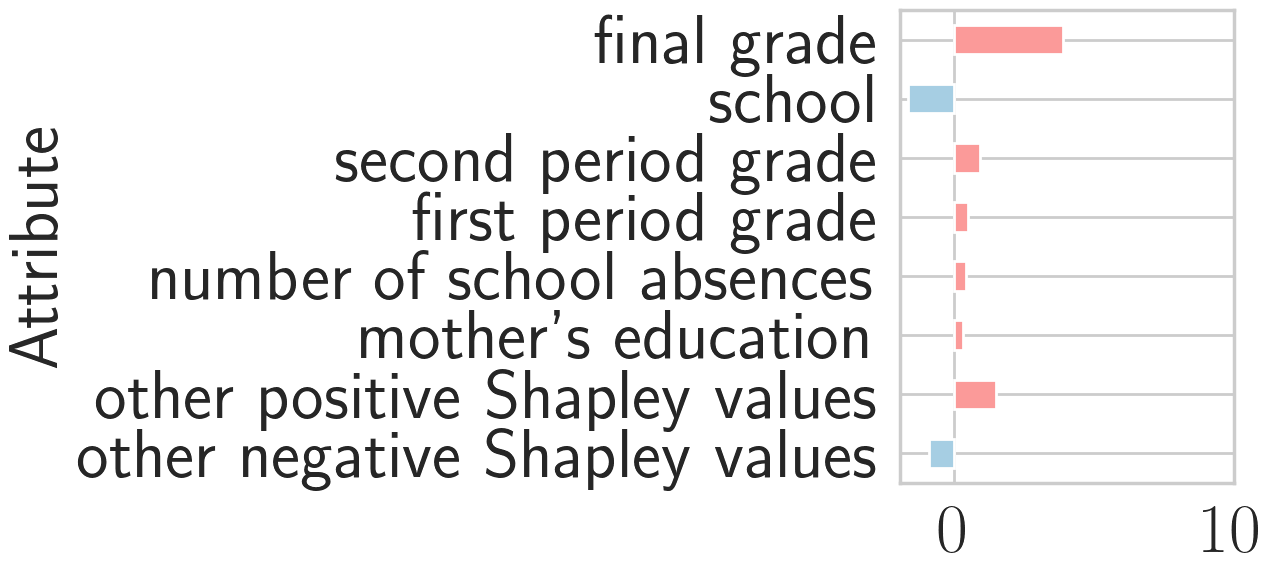

In [26]:

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
plot_average_shap_value_of_group(ranked_data[all_attributes], group, selected_attributes, all_attributes_original, shap_values, ax)
plt.xticks([0, 10], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"shap_PStatus_T.png", bbox_inches='tight')
plt.show()



Att = G3
unique values of G3 = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
num of tuples in group 354 = [-1, -1, -1, -1, -1, 'T']
x:  [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.5, 0.1]
x:  [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y: [0.101695, 0.002825, 0.019774, 0.033898, 0.019774, 0.087571, 0.070621, 0.144068, 0.110169, 0.079096, 0.076271, 0.073446, 0.084746, 0.042373, 0.014124, 0.028249, 0.008475, 0.002825]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


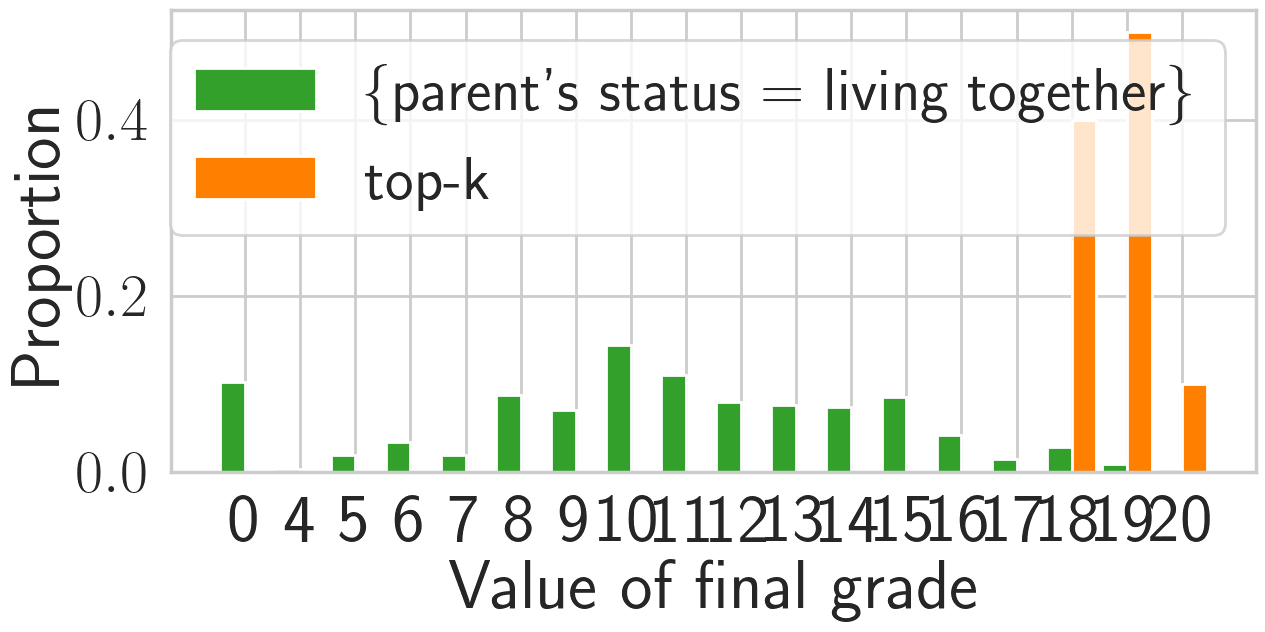

In [28]:
group_name = "\{parent's status = living together\}"


original_att = 'final grade'
get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k)


Att = Medu
unique values of Medu = [0, 1, 2, 3, 4]
num of tuples in group 354 = [-1, -1, -1, -1, -1, 'T']
x:  [0, 1, 2, 3, 4]
y: [0.0, 0.0, 0.1, 0.2, 0.7]
x:  [0, 1, 2, 3, 4]
y: [0.008475, 0.163842, 0.271186, 0.228814, 0.327684]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


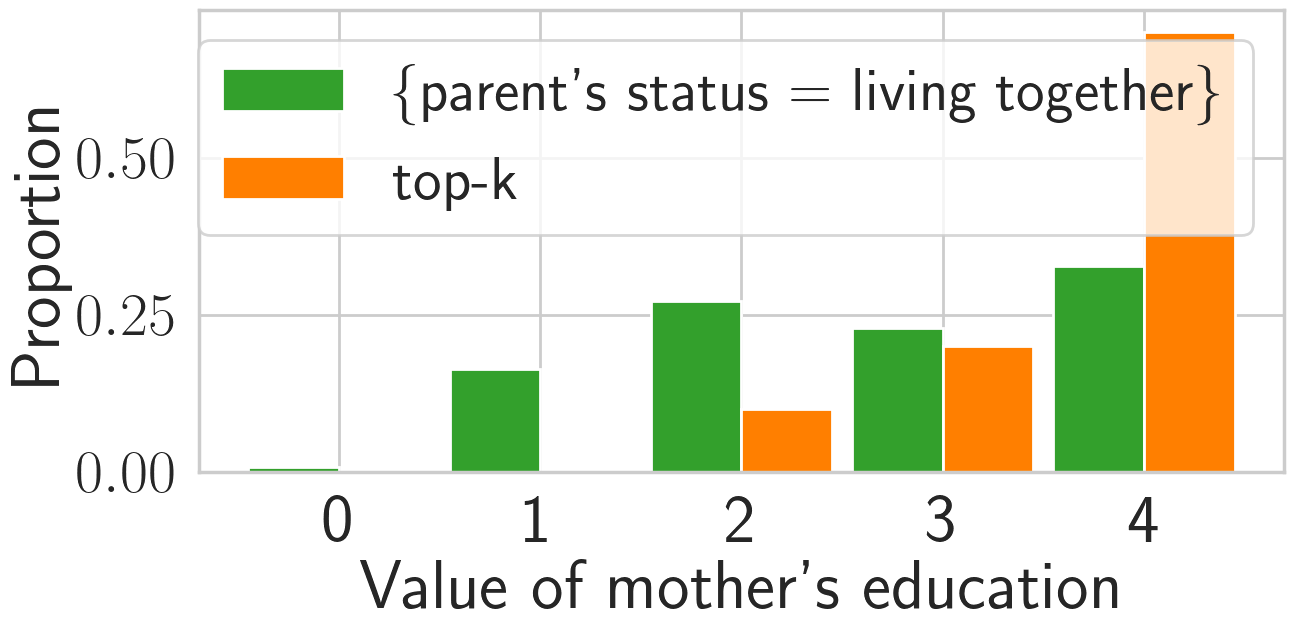

In [29]:
group_name = "\{parent's status = living together\}"


original_att = 'mother\'s education'
get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k)


Att = school
unique values of school = ['GP', 'MS']
num of tuples in group 354 = [-1, -1, -1, -1, -1, 'T']
x:  ['GP', 'MS']
y: [0.9, 0.1]
x:  ['GP', 'MS']
y: [0.878531, 0.121469]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


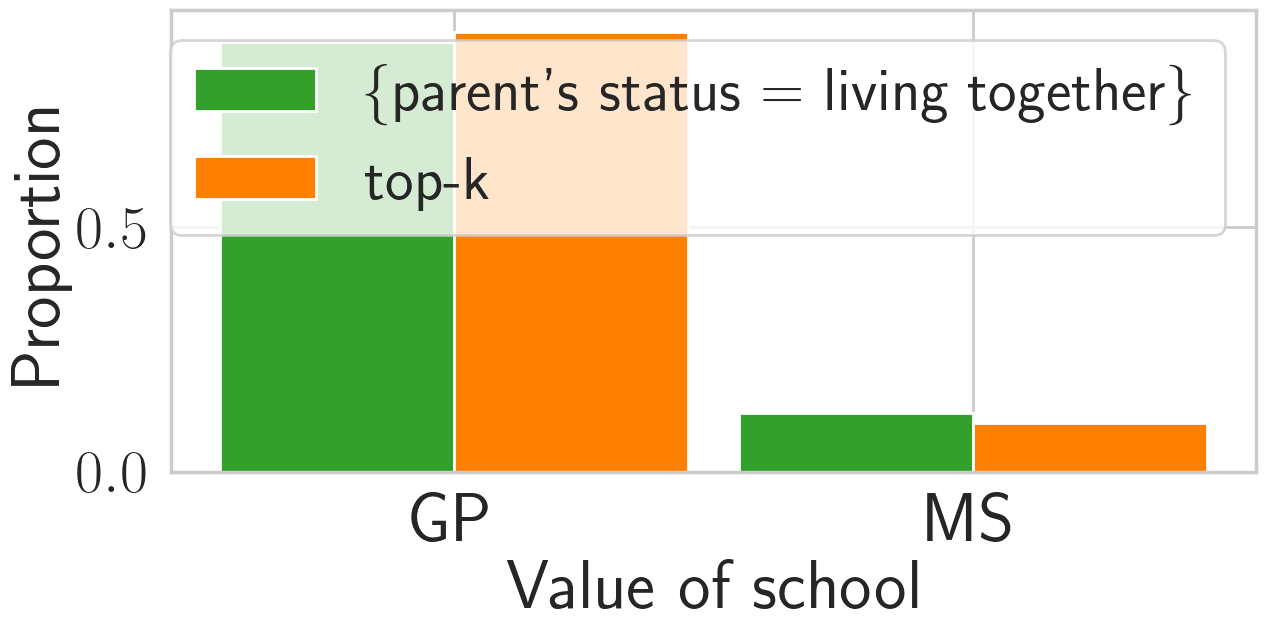

In [30]:
group_name = "\{parent's status = living together\}"


original_att = 'school'
get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k)


# another group

In [31]:
k = 11
group = groups_prop_bounds[k][3]['group in list']
print(group)


[-1, -1, -1, 'R', -1, -1]


group [-1, -1, -1, 'R', -1, -1] size 88
                       Attribute  Shapley values
7  other negative Shapley values       -2.592026
6  other positive Shapley values        4.368171
5                            age        1.653361
4                         school        1.751114
3                        address        2.106916
2             first period grade        3.908095
1            second period grade        4.096822
0                    final grade       16.861517
[-2.592026, 4.368171, 1.653361, 1.751114, 2.106916, 3.908095, 4.096822, 16.861517]
['other negative Shapley values', 'other positive Shapley values', 'age', 'school', 'address', 'first period grade', 'second period grade', 'final grade']


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


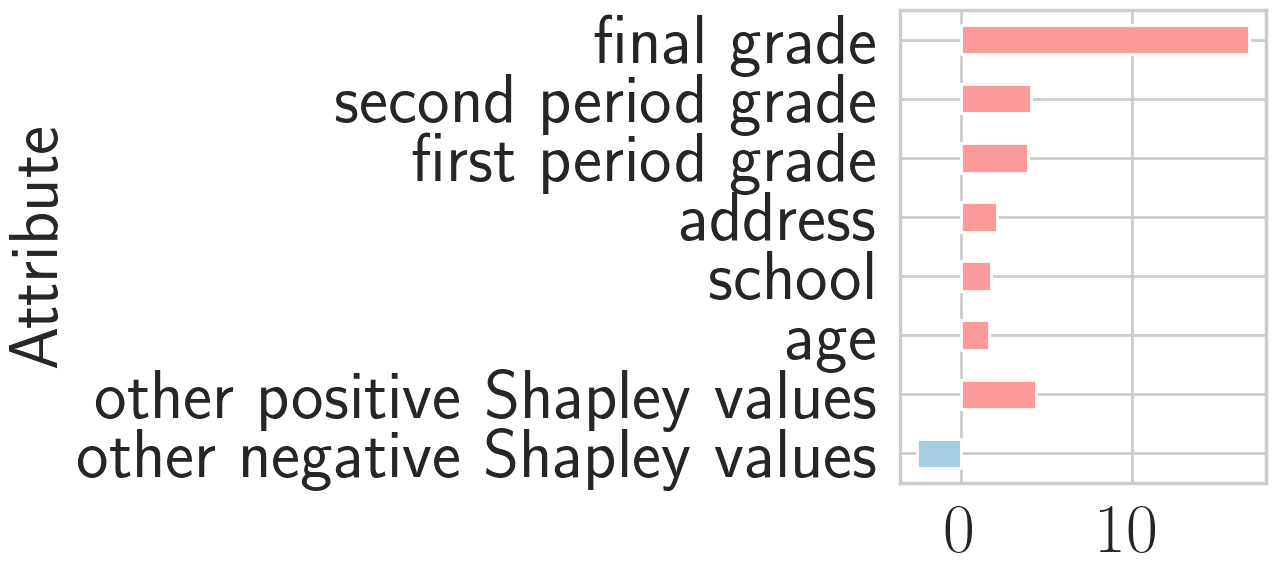

In [32]:

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
plot_average_shap_value_of_group(ranked_data[all_attributes], group, selected_attributes, all_attributes_original, shap_values, ax)
plt.xticks([0, 10], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"shap_address_R.png", bbox_inches='tight')
plt.show()



Att = G3
unique values of G3 = [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
num of tuples in group 88 = [-1, -1, -1, 'R', -1, -1]
x:  [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.454545, 0.454545, 0.090909]
x:  [0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y: [0.113636, 0.0, 0.045455, 0.034091, 0.068182, 0.079545, 0.034091, 0.193182, 0.113636, 0.090909, 0.079545, 0.034091, 0.034091, 0.034091, 0.011364, 0.022727, 0.011364, 0.0]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


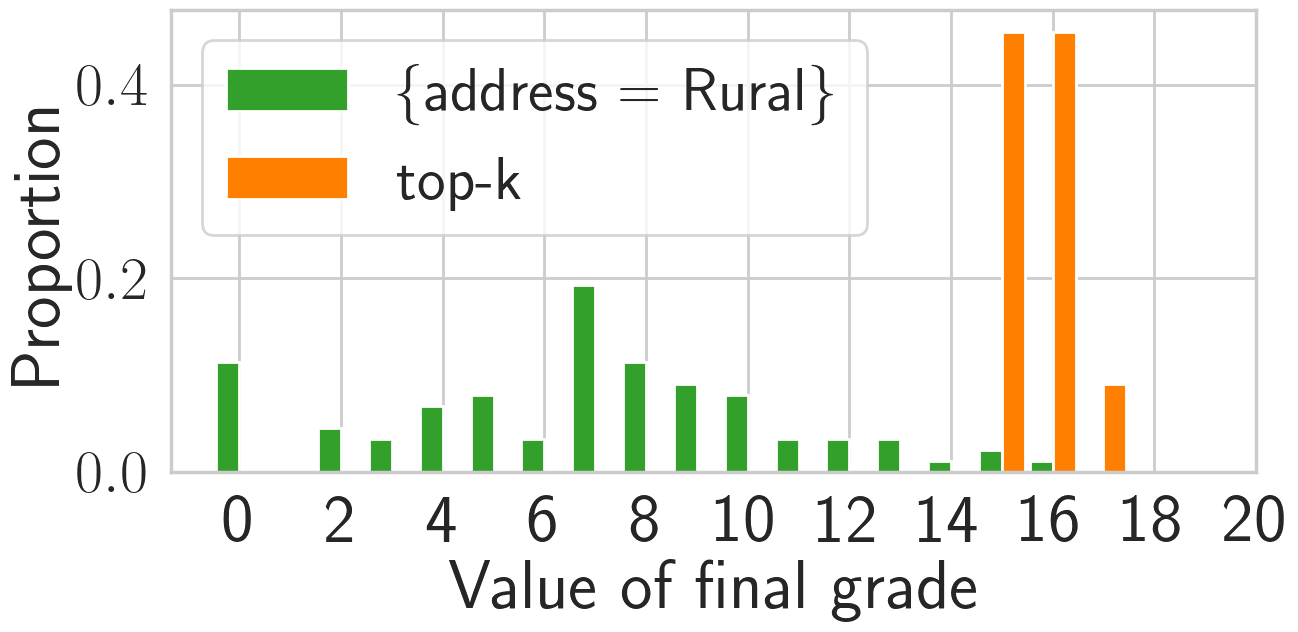

In [41]:
group_name = "\{address = Rural\}"


original_att = 'final grade'
get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k)
# plt.savefig(r"Val_dis_address_R_final_grade.png", bbox_inches='tight')

Att = school
unique values of school = ['GP', 'MS']
num of tuples in group 88 = [-1, -1, -1, 'R', -1, -1]
x:  ['GP', 'MS']
y: [0.909091, 0.090909]
x:  ['GP', 'MS']
y: [0.715909, 0.284091]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


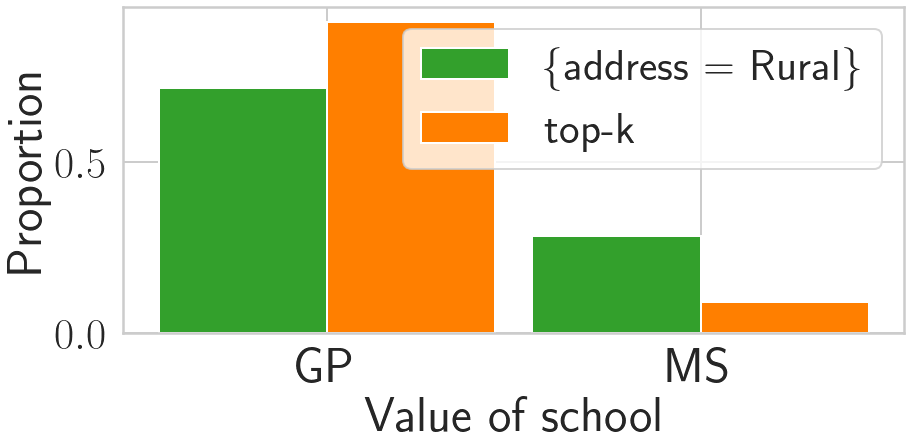

In [19]:
group_name = "\{address = Rural\}"


original_att = 'school'
get_dis_plot(ranked_data, selected_attributes, all_attributes, all_attributes_original, original_att, group, group_name, k)


another set of att

In [40]:
num_att = 6
selected_attributes = ['sex', 'age', 'famsize', 'Pstatus', 'Medu',
                      'Fedu']
print(selected_attributes)
alpha = 0.8
k = 10
k_min = 10
k_max = 16
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_, patterns_size_whole_prop \
            = propbounds.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = []
for k in range(k_min, k_max):
    groups_prop_bounds.append([string2list(k) for k in list(result_prop_bounds[k - k_min])])
    print("k = {}, {} groups founded".format(k, len(groups_prop_bounds[k-k_min])))
    for g in groups_prop_bounds[k-k_min]:
        print(g)


['sex', 'age', 'famsize', 'Pstatus', 'Medu', 'Fedu']
k = 10, 9 groups founded
['F', -1, -1, -1, -1, -1]
[-1, -1, -1, 'T', -1, -1]
[-1, -1, -1, -1, -1, 1]
[-1, -1, -1, -1, 2, -1]
[-1, -1, -1, -1, 1, -1]
[-1, -1, 'GT3', -1, -1, -1]
[-1, 17, -1, -1, -1, -1]
[-1, -1, -1, -1, 3, -1]
[-1, 16, -1, -1, -1, -1]
k = 11, 9 groups founded
[-1, -1, -1, 'T', 3, -1]
['F', -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1]
[-1, -1, -1, -1, 2, -1]
[-1, -1, -1, 'T', -1, 2]
[-1, -1, -1, -1, 1, -1]
[-1, 16, -1, -1, -1, -1]
[-1, -1, 'GT3', -1, -1, -1]
[-1, 17, -1, -1, -1, -1]
k = 12, 10 groups founded
[-1, -1, 'GT3', 'T', -1, -1]
['F', -1, -1, -1, -1, -1]
[-1, 18, 'GT3', -1, -1, -1]
[-1, -1, 'GT3', -1, -1, 2]
[-1, -1, -1, -1, -1, 1]
[-1, -1, -1, -1, 2, -1]
[-1, -1, -1, 'T', -1, 2]
[-1, -1, -1, -1, 1, -1]
[-1, 17, -1, -1, -1, -1]
[-1, -1, -1, 'T', 3, -1]
k = 13, 8 groups founded
[-1, -1, -1, 'T', 3, -1]
[-1, -1, -1, -1, -1, 2]
['F', -1, -1, -1, -1, -1]
[-1, 18, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1]
[-1, -1, -1, 

In [41]:

shap_values = get_shap_values(ranked_data, all_attributes)



school ['GP', 'MS']
sex ['F', 'M']
address ['R', 'U']
famsize ['GT3', 'LE3']
Pstatus ['A', 'T']
Mjob ['at_home', 'health', 'other', 'services', 'teacher']
Fjob ['at_home', 'health', 'other', 'services', 'teacher']
reason ['course', 'home', 'other', 'reputation']
guardian ['father', 'mother', 'other']
schoolsup ['no', 'yes']
famsup ['no', 'yes']
paid ['no', 'yes']
activities ['no', 'yes']
nursery ['no', 'yes']
higher ['no', 'yes']
internet ['no', 'yes']
romantic ['no', 'yes']
Model coefficients:

school = 8.56684
sex = -3.96828
age = 8.82744
address = -13.22346
famsize = 0.10814
Pstatus = -4.35951
Medu = -4.26817
Fedu = -0.50821
Mjob = 4.86519
Fjob = 2.46173
reason = -2.30278
guardian = 0.55674
traveltime = -3.88126
studytime = -0.72349
failures = -2.62461
schoolsup = 15.4088
famsup = 6.87716
paid = -6.77001
activities = -5.29067
nursery = 3.64442
higher = 10.04959
internet = -0.65319
romantic = 1.66049
famrel = -5.19991
freetime = 1.92956
goout = 3.86379
Dalc = 0.15863
Walc = -0.78833


[-1, -1, -1, -1, 3, -1]
group [-1, -1, -1, -1, 3, -1] size 99
                       Attribute  Shapley values
0                    final grade        5.148582
1             first period grade       -1.071246
2            second period grade        1.032174
3                   mother's job        0.985323
4    extra-curricular activities        0.928807
5               student's school       -0.761497
6  other positive Shapley values        3.346856
7  other negative Shapley values       -2.704862


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


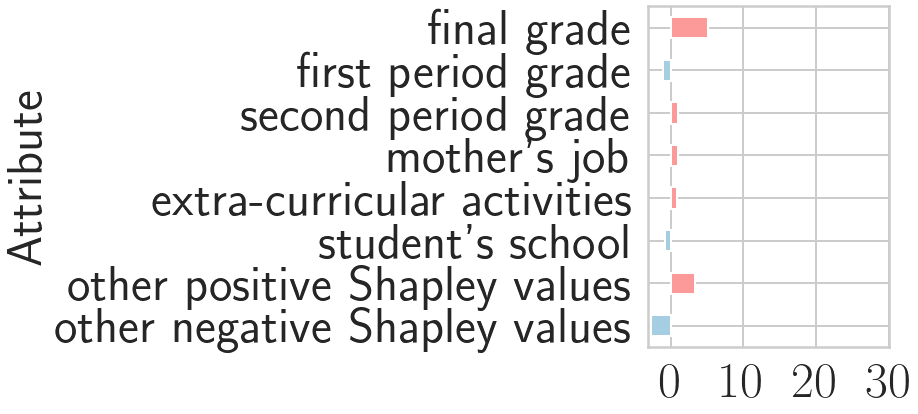

In [48]:
group = groups_prop_bounds[0][7]
print(group)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
plot_average_shap_value_of_group(ranked_data[all_attributes], group, selected_attributes, all_attributes_original, shap_values, ax)
plt.xticks([0, 10, 20, 30], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"student_shap_globalbounds.png", bbox_inches='tight')
plt.show()

